University of Helsinki, Master's Programme in Mathematics and Statistics  
MAST32001 Computational Statistics, Autumn 2023  
Luigi Acerbi  

# Week 6 exercises

## 1. Leapfrog integration in HMC (4 points)

In this exercise we will experiment with the leapfrog integrator used in HMC. As a target, we will use the 2D correlated normal 
$$ \pi(\boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta} ;\; 0, \boldsymbol{\Sigma}_2), $$
where $ \boldsymbol{\Sigma}_2 = \begin{pmatrix} 1 & \rho \\ \rho & 1 \end{pmatrix}$ with $\rho = 0.998$.

1. Simulate the system for $L=10$ leapfrog steps starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $r = (1, 1/3)$ with several values of $\epsilon$ and plot the resulting Metropolis-Hastings acceptance probabilities $a$ at the end of the leapfrog trajectory. Considering values of $\epsilon \in [0.001, 0.1]$:
  - What is the smallest $\epsilon$ that will yield acceptance probability below 60%? 
  - What is the largest $\epsilon$ that will yield an acceptance probability above 10%?
  - For this exercise, the required tolerance on the answer is 0.001.
2. Simulate the Hamiltonian system for 500 leapfrog steps with $\epsilon=0.05$ starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $r = (1, 1/3)$. Plot the trajectory and the Euclidean distance from the starting point at each point. 
  - How many leapfrog steps do you need to take until the trajectory reaches the first local maximum distance from the origin?
  - How many leapfrog steps (since the start of the trajectory) will lead you to the first local minimum?

*Note*: This exercise tests only the deterministic leapfrog integration used within the HMC algorithm to produce a single proposal. **This procedure is completely deterministic.** You will not need any random number generators in your solution. In particular, you will not need to run the full HMC algorithm or make any actual accept/reject decisions.

smallest eps below 60% = 0.082
largest eps above 10% = 0.08800000000000001
[0.052704627669472995, 0.09586589661981748, 0.14156157639897846, 0.18968230598313918, 0.23468717063026456, 0.28141451375006216, 0.3274899299209829, 0.3721913082575186, 0.41791836339756666, 0.46202244221987826, 0.505801444627284, 0.5495456784892988, 0.5916192045622554, 0.6337627832943477, 0.6748911396510237, 0.7147733953873341, 0.7545093311316072, 0.7926495622832884, 0.8300189481591881, 0.8666435258912782, 0.9015818307324475, 0.9359556511495462, 0.9689390087556053, 1.000492688615039, 1.0313043594959632, 1.0603216050549444, 1.0882371824279342, 1.114955627537381, 1.1398361148341334, 1.1637571964691538, 1.1859911042620084, 1.2066195334854082, 1.2261339326907583, 1.2436734492894725, 1.2598982597886763, 1.2746342663475083, 1.2874165255095433, 1.2990136907515217, 1.3087323545871004, 1.3167566317351453, 1.3234652145081818, 1.3281005717291396, 1.3313434434113132, 1.3329502387467658, 1.3325791393561008, 1.3309574709670486

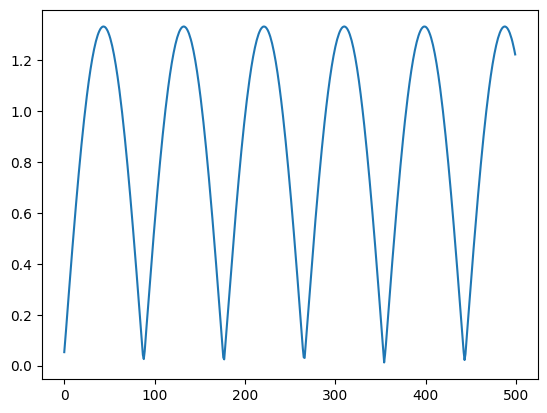

In [238]:
import autograd.numpy as np 
import matplotlib.pyplot as plt
from autograd import grad
from autograd.scipy import stats

def H(theta, r):
    return -pi(theta) + (1/2)*(np.sum(r**2))

def pi(theta):
    sig = np.array([[1, 0.998], [0.998, 1]])
    return stats.multivariate_normal.logpdf(theta, mean=np.zeros(2), cov=sig)

grad_logpdf_target = grad(pi)
    
def leapfrog(theta, r, epsilon, L):
    for _ in range(L):
        r = r + (epsilon / 2) * grad_logpdf_target(theta)
        theta = theta + epsilon * r
        r = r + (epsilon / 2) * grad_logpdf_target(theta)
        
    return theta, r

acceptance_rates = []
x = np.linspace(0.001, 0.1, 100)
H_orig = H(np.array([0,0]), np.array([1,1/3]))

for eps in x:
    theta_new, r_new = leapfrog(np.array([0,0]), np.array([1,1/3]), eps, 10)
    
    H_new = H(theta_new, r_new)
    acceptance_rates.append(np.exp(H_orig - H_new))

index_below_60 = next((i for i, v in enumerate(acceptance_rates) if v < 0.6), None)
index_above_10 = len(acceptance_rates) - 1 - next((i for i, v in enumerate(reversed(acceptance_rates)) if v > 0.1), None)

print(f'smallest eps below 60% = {x[index_below_60]}')
print(f'largest eps above 10% = {x[index_above_10]}')
# plt.plot(x, acceptance_rates)

distances = []
theta_0 = np.array([0,0])
r_0 = np.array([1, 1/3])

theta_i = theta_0.copy()
r_i = r_0.copy()

for _ in range(500):
    # H_old = H(theta_i, r)
    theta_i, r_i = leapfrog(theta_i, r_i, 0.05, 1)
    # H_new = H(theta_i, r)
    distances.append(np.linalg.norm(theta_0-theta_i))
distances = distances
print(distances)
plt.plot(np.arange(len(distances)), distances)

## 2. Efficiency of "random walk" MCMC and HMC (4 points)

In this exercise we will test the efficiency of Metropolis-Hastings (also known as "random walk" MCMC) and HMC in terms of the distance covered in various situations. 

All the experiments are done using the same correlated normal target as in Exercise 1.
For Metropolis-Hastings MCMC, we will use as proposal $q(\boldsymbol{\theta}'; \boldsymbol{\theta}) = \mathcal{N}(\boldsymbol{\theta}'; \boldsymbol{\theta}, \sigma^2 \mathbf{I}_2)$ with $\sigma = 0.01$. For HMC, set $\epsilon=0.01$ and $L$ as specified below.

Distance covered here means the distance between the final point and the starting point of the chain, ignoring any intermediate steps.

1. Always starting at $\boldsymbol{\theta}_0 = (0, 0)$, run Metropolis-Hastings MCMC 100 times for 1 step and 100 times for 100 steps. Compute the average Euclidean distance covered from the starting point in each case. Compare the 100 step distance with the theoretical random walk scaling of $\sqrt{n}$ over $n$ steps.
2. Always starting at $\boldsymbol{\theta}_0 = (0, 0)$, run HMC 100 times for 1 step with $L=1$ and 100 times for 1 step with $L=100$. Compute the average Euclidean distance covered from the starting point in each case. Compare the 100 step distance with the theoretical random walk scaling of $\sqrt{n}$ over $n$ steps.
3. Repeat task 1 starting at $\boldsymbol{\theta}_0 = (-2, 2)$.
4. Repeat task 2 starting at $\boldsymbol{\theta}_0 = (-2, 2)$.
5. In each case, report the two average Euclidean distances in Moodle. In which cases do the algorithms move more quickly than would be expected for a random walk?

In [232]:

eps = 0.01
sig = (0.01**2) * np.eye(2)

def mcmc(N, theta_0):
    theta_i = theta_0.copy()

    theta_samples = []
    for _ in range(N):
        theta_i_p_1 = np.random.multivariate_normal(theta_i, sig)

        a = np.exp(pi(theta_i_p_1) - pi(theta_i))
        if (np.random.uniform() < a):
            theta_i = theta_i_p_1
        theta_samples.append(theta_i)
        
    return theta_i
    
distances_N_1 = np.array([np.linalg.norm(theta_0-mcmc(1, np.array([0,0])))  for _ in range(100)])
distances_N_100 = np.array([np.linalg.norm(theta_0-mcmc(100, np.array([0,0])))  for _ in range(100)])

print(f'(1) distances_N_1={distances_N_1.mean()} distances_N_100={distances_N_100.mean()}')

def mcmc_hmc(N, L, theta_0):
    theta_i = theta_0.copy()
    r_i = np.array([1, 1/3])

    for _ in range(N):
        theta_i_p1, r_i_p_1 = leapfrog(theta_i, r_i, eps, L)
        
        H_i = H(theta_i, r_i)
        H_i_p_1 = H(theta_i_p1, r_i_p_1)
        
        a = np.exp(H_i - H_i_p_1)
        
        if np.random.uniform() < a:
            theta_i = theta_i_p1
            
    return theta_i

distances_L_1 = np.array([np.linalg.norm(np.array([0,0])-mcmc_hmc(1, 1, np.array([0,0])))  for _ in range(100)])
distances_L_100 = np.array([np.linalg.norm(np.array([0,0])-mcmc_hmc(1, 100, np.array([0,0])))  for _ in range(100)])
print(f'(2) distances_L_1={distances_L_1.mean()} distances_L_100={distances_L_100.mean()}')

distances_N_1 = np.array([np.linalg.norm(np.array([-2,2])-mcmc(1, np.array([-2,2])))  for _ in range(100)])
distances_N_100 = np.array([np.linalg.norm(np.array([-2,2])-mcmc(100, np.array([-2,2])))  for _ in range(100)])
print(f'(3) theta_0=[-2, 2] distances_N_1={distances_N_1.mean()} distances_N_100={distances_N_100.mean()}')

distances_L_1 = np.array([np.linalg.norm(np.array([-2,2])-mcmc_hmc(1, 1, np.array([-2,2])))  for _ in range(100)])
distances_L_100 = np.array([np.linalg.norm(np.array([-2,2])-mcmc_hmc(1, 100, np.array([-2,2])))  for _ in range(100)])
print(f'(4) theta_0=[-2, 2] distances_L_1={distances_L_1.mean()} distances_L_100={distances_L_100.mean()}')

(1) distances_N_1=0.01189682718323977 distances_N_100=0.09713866034271974
(2) distances_L_1=0.0105409255338946 distances_L_100=0.8661572179590563
(3) theta_0=[-2, 2] distances_N_1=0.005507805497695263 distances_N_100=0.4055929460561927
(4) theta_0=[-2, 2] distances_L_1=0.0760116950066092 distances_L_100=5.475544779391072


## 3. NUTS simulation (6 points)

In this exercise we will experiment with the build-tree operation of the NUTS algorithm. We will use a simplified version of the algorithm with the following differences from the original:
* We will only extend the path forward instead of choosing the direction randomly.
* We will check for the termination condition only from the entire newly added path segment, not all subpaths as NUTS really would.

Your tasks:
1. Implement a simplified version of NUTS that works as follows:
  - Start at iteration $j = 1$.
  - In each iteration $j$, with $j = 1,2,\ldots$, set $L = 2^{j-1}$ and run $L$ leapfrog steps forward. Deterministically move to the new position (i.e., there is no acceptance check). 
  - At the end of each iteration, a "termination check" is run. The algorithm stops when the first newly simulated position $(\boldsymbol{\theta}^-, \mathbf{r}^-)$ and the last newly simulated position $(\boldsymbol{\theta}^+, \mathbf{r}^+)$ of the trajectory simulated in the current iteration segment satisfy
$$ (\boldsymbol{\theta}^+ - \boldsymbol{\theta}^-) \cdot \mathbf{r}^- < 0 \quad \text{or} \quad (\boldsymbol{\theta}^+ - \boldsymbol{\theta}^-) \cdot \mathbf{r}^+ < 0. $$
2. Run your algorithm on the 2D correlated normal with $\rho = 0.998$, starting from the origin $\boldsymbol{\theta}_0 = (0, 0)$ with momentum $\mathbf{r} = (1, 1/3)$ with $\epsilon=0.05$. At which iteration $j$ of the algorithm will the termination criterion be triggered for the first time? Report the iteration number in Moodle.
3. Compute the distance from the origin of the point at which the termination criterion is triggered, and report it in Moodle.
4. NUTS includes a special condition to simulate $u \sim \mathrm{Uniform}(0, \exp(-H(\boldsymbol{\theta}_0, \mathbf{r}_0))$ and ignoring all points where $u > \exp(-H(\boldsymbol{\theta}, \mathbf{r}))$. Assuming $u = 0.98\exp(-H(\boldsymbol{\theta}_0, \mathbf{r}_0))$ (a pretty extreme value), how many points from the trajectory of $2^j$ points generated during the first $j$ iterations (including the initial state and the one during which the termination condition was triggered first) would be included in the next step of the algorithm when choosing the next point?

In [254]:
theta_0 = np.array([0, 0])
r_0 = np.array([1, 1/3])
eps = 0.05

def NUTS():
    theta_i, r_i = theta_0.copy(), r_0.copy()
    samples = [(theta_i, r_i)]

    for j in range(1, 200):
        L = 2**(j-1)
        theta_i_p_1, r_i_p_1 = leapfrog(theta_i, r_i, eps, L)
        samples.append((theta_i_p_1, r_i_p_1))
        if(np.dot(theta_i_p_1 - theta_i, r_i) < 0 or np.dot(theta_i_p_1 - theta_i, r_i_p_1) < 0):
            return j, theta_i_p_1, samples
        
        theta_i, r_i = theta_i_p_1, r_i_p_1


j, theta_t, samples = NUTS()
print(f'(1,2) j={j} distance={np.linalg.norm(theta_0-theta_t)}')

u = 0.98*np.exp(-H(theta_0, r_0))

accepted_samples = [theta for theta, r in samples if u <= np.exp(-H(theta, r))]
print(accepted_samples)


(1,2) j=6 distance=1.0548530007565315
[array([0, 0]), array([0.09254155, 0.10712489]), array([0.73486068, 0.7567659 ])]


## 4. HMC sampling for posterior inference (6 points)

In this task we will apply HMC sampling for posterior inference of a linear regression model.
We will use data from the Framingham Heart Study that studies the association between heart disease and its causes.
A description of the data and its fields can be found at http://www.maths.utas.edu.au/DHStat/Data/Flow.html (see also problem 10.4 in the computer tasks done in class).

We will use a linear regression model
$$ y_i = \mathbf{x}_i \boldsymbol{\beta} + \epsilon_i, $$
where $\mathbf{x}_i$ is a row vector of input variables and $\boldsymbol{\beta}$ is a column vector of regression coefficients, and the noise term $\epsilon_i$ follows the normal $\mathcal{N}(0, \sigma_y^2)$. We will not need a constant intercept term in the model because we will standardise the data.

Assuming the residuals $\epsilon_i, i=1,\dots,n$ are independent, the log-likelihood of the model is
$$ \log p(y | x, \boldsymbol{\beta}, \sigma_y) = \sum_{i=1}^n \log p(y_i | \boldsymbol{\beta}, x_i, \sigma_y) = \sum_{i=1}^n \log \mathcal{N}(y_i; \; \mathbf{x}_i \boldsymbol{\beta}, \sigma_y^2). $$

1. Load the data using the below code. Standardise the data (both $x$ and $y$) by subtracting the mean and dividing each variable by **two** standard deviations (see http://www.stat.columbia.edu/~gelman/research/published/standardizing7.pdf). Fit all the models using the standardised data as this makes sampling a lot easier.
2. Using the above log-likelihood and priors
$$ p(\boldsymbol{\beta}) = \prod_j p(\beta_j) = \prod_j \mathcal{N}(\beta_j;\; 0, 2^2), \\ p(\sigma_y) = \mathrm{Gamma}(\sigma_y;\; k=10, \theta=0.1),$$
use HMC or NUTS to draw samples from the posterior distribution $p(\boldsymbol{\beta}, \sigma_y | x, y)$, when the prediction target variable $y$ is 'SBP' and the input variables $x$ are 'FRW', 'AGE' and 'CHOL'.

To ensure the standard deviation $\sigma_y$ is positive, express it as $\sigma_y = \exp(s_y)$, where $s_y$ is unbounded. Remember to apply the density transformation to transform the prior over $\sigma_y$ to that over $s_y$!

Make sure your sampler is properly tuned so that results will be reliable.

Report your estimates of the posterior means and standard deviations of the coefficient in $\beta$ for 'FRW', and of $s_y$. (*Note*: This should be $s_y$, not $\sigma_y$!)

Implementations of the gamma log-pdf needed for the prior that are compatible with Autograd and PyTorch are provided below for your convenience. (Autograd does not support `scipy.stats.gamma.logpdf` to the level we need. The PyTorch library implementation uses a different parametrisation, so the below implementation is easier for consistency.)

The required tolerance is $\pm 0.01$.

*Note*: The NUTS implementation provided in the course materials sometimes gets stuck and produces a sample with really small variance. If you encounter such behaviour, you should disregard such results.

0.0016376376376376377
rate=0.98
beta_FRW mean=0.31579953084359375, std=0.00022374866266538428
s_y mean=-0.7673212246797022, std=0.021078387436713825


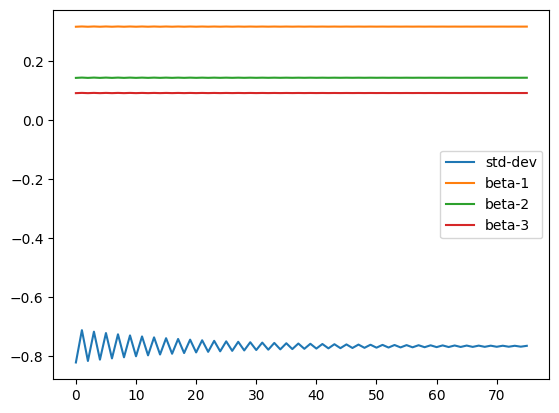

In [272]:
# For autograd
import pandas as pd
import autograd.numpy as np
import autograd.scipy.special as scs
from autograd import grad
import matplotlib.pyplot as plt



# load the data from CSV file using pandas
fram = pd.read_csv('https://raw.githubusercontent.com/lacerbi/compstats-files/main/data/fram.txt', sep='\t')
# convert the variables of interest to numpy arrays for autograd compatibility
# input: Framingham relative weight - the ratio of the subjects weight to the median weight for their sex-height group,
#   age and cholesterole level
x = fram[['FRW', 'AGE', 'CHOL']].values.astype(float)
# target: Systolic blood pressure, examination 1
y = fram['SBP'].values.squeeze().astype(float)

def standardize(x):
    return (x - np.mean(x, axis=0)) / (2 * np.std(x, axis=0))

xs = standardize(x)
ys = standardize(y)

def gamma_logpdf(x, k, theta):
    """Gamma distribution log pdf."""
    return -scs.gammaln(k) - k*np.log(theta) + (k-1)*np.log(x) - x / theta

def log_likelihood(beta, s_y, xs, ys):
    # Transform s_y to sigma_y
    sigma_y = np.exp(s_y)
    
    # Compute the model predictions
    mu = np.dot(xs, beta)
    
    # Compute residuals
    residuals = ys - mu
    
    # Compute the log-likelihood
    ll = -0.5 * np.sum(np.log(2 * np.pi * sigma_y**2) + (residuals / sigma_y)**2)
    
    return ll

# Target
def log_posterior(params, xs, ys):
    beta, s_y = params[:-1], params[-1] # first 3 is beta, and the last is std-dev if y
    sig_y = np.exp(s_y)
    log_prior_sy =  gamma_logpdf(sig_y, k=10, theta=0.1) + s_y
    log_prior_beta = -0.5 * np.sum(beta**2 / 4)

    return log_likelihood(beta, s_y, xs, ys) + log_prior_sy + log_prior_beta

grad_logpdf_target = grad(lambda params: log_posterior(params, xs, ys))

def H(theta, r):
    return -log_posterior(theta, xs, ys) + (1/2)*(np.sum(r**2))

def leapfrog(params, r, epsilon, L):
    for _ in range(L):
        r = r + (epsilon / 2) * grad_logpdf_target(params)  # half step update for momentum
        params = params + epsilon * r  # full step update for parameters
        r = r + (epsilon / 2) * grad_logpdf_target(params)  # half step update for momentum
        
    return params, r

def mcmc_hmc(N, L, eps, params_0):
    theta_i = params_0.copy()
    r_i = np.array([0.1, 0.1, 0.1, 0.1])
    samples = [theta_i]
    rate = 0
    for _ in range(N):
        theta_i_p1, r_i_p_1 = leapfrog(theta_i, r_i, eps, L)
        
        H_i = H(theta_i, r_i)
        H_i_p_1 = H(theta_i_p1, r_i_p_1)
        
        a = np.exp(H_i - H_i_p_1)
        
        if np.random.uniform() < a:
            theta_i = theta_i_p1
            rate +=1

        samples.append(theta_i)
            
    print(f'rate={rate/N}')
    return theta_i,samples

# for eps in np.linspace(0.001, 0.05, 1000):
print(eps)
params, samples = mcmc_hmc(200, 40, 0.0016376376376376377, np.array([1, 1, 1, -0.7]))
samples = np.array(samples)[len(samples)//2:]
plt.plot(range(len(samples)), samples[:,3], label="std-dev")

plt.plot(range(len(samples)), samples[:,0], label="beta-1")
plt.plot(range(len(samples)), samples[:,1], label="beta-2")
plt.plot(range(len(samples)), samples[:,2], label="beta-3")

print(f'beta_FRW mean={np.mean(samples[:,0])}, std={np.std(samples[:,0])}')
print(f's_y mean={np.mean(samples[:,3])}, std={np.std(samples[:,3])}')

plt.legend()